In [1]:
%pylab
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
# load train data and test data and the transform to customer_id-item_id-quantity matrix, then fill the null value to 0
train_data = pd.read_csv("data/train_data.csv")
test_data = pd.read_csv("data/test_data.csv")
train_matrix = pd.pivot_table(train_data, values="quantity", index=["customer_id"], columns=["item_id"],
                             aggfunc=np.sum, fill_value=0)
test_matrix = pd.pivot_table(test_data, values="quantity", index=["customer_id"], columns=["item_id"],
                            aggfunc=np.sum, fill_value=0)

In [3]:
print "train_matrix: %s, test_matrix: %s" % (train_matrix.shape, test_matrix.shape)

train_matrix: (4889, 3365), test_matrix: (437, 578)


In [4]:
# R_t is the input test matrix represented using numpy, and naming is in accordance with paper
# R is the input train matrix
R_t = test_matrix.values
R = train_matrix.values

In [6]:
# finding the index of non-zero element in test matrix R_t
test_nonzero_index = np.nonzero(R_t)   # test_nonzero_index is a tuple, first is x-coordinate, second is y-coordinate
len(test_nonzero_index[0])

1025

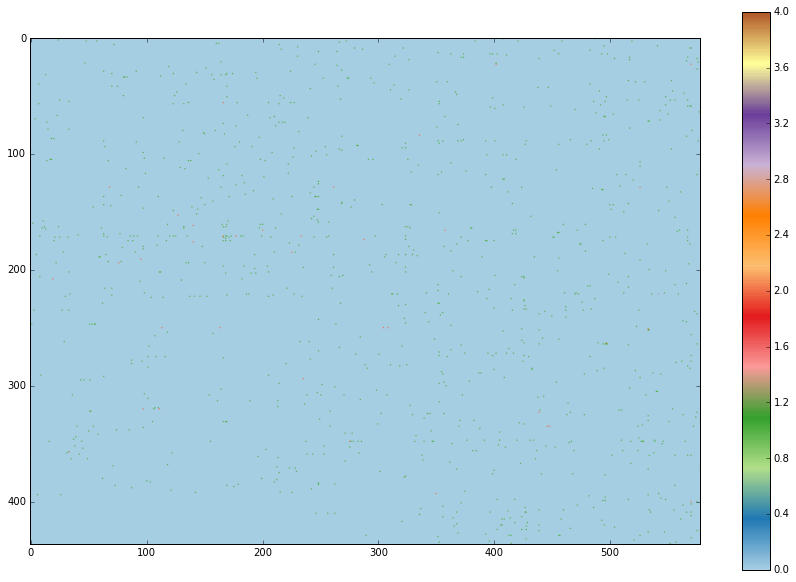

In [17]:
# the data distribution in test matrix
plt.figure(figsize=(15,10))
plt.imshow(R_t, cmap=plt.cm.Paired)
plt.colorbar()
plt.show()

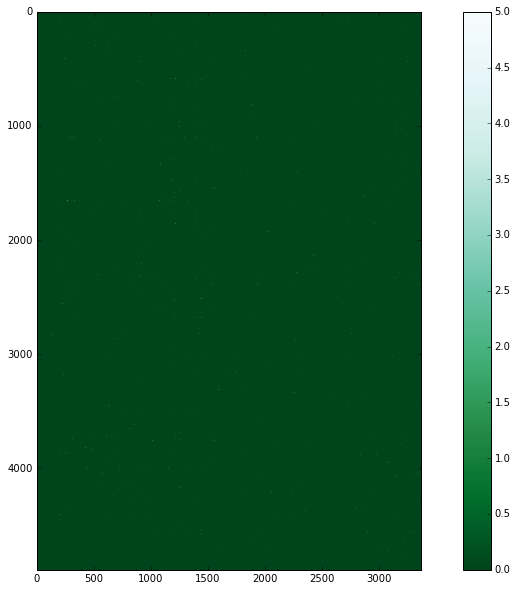

In [24]:
# the data distribution in train matrix
plt.figure(figsize=(15,10))
plt.imshow(R, cmap=plt.cm.BuGn_r)
plt.colorbar()
plt.show()

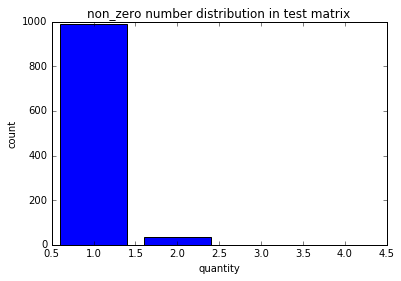

In [31]:
# get the distribution of the non-zero element in test matrix R_t
fig = plt.figure()
axes = fig.add_subplot(111)

non_zero_element_distribution = np.unique(R_t[test_nonzero_index], return_counts=True)
axes.bar(non_zero_element_distribution[0], non_zero_element_distribution[1], align="center")
plt.xticks()

plt.xlabel("quantity")
plt.ylabel("count")
plt.title("non_zero number distribution in test matrix")

plt.show()

In [32]:
non_zero_element_distribution

(array([1, 2, 3, 4]), array([988,  35,   1,   1]))

In [33]:
### for each non_zero element in test, find the corresponding index in train of the same customer and item
customer_id_index_in_train = []
item_id_index_in_train = []
for i in xrange(len(test_nonzero_index[0])):
    customer_id_index_in_train.append(np.where(train_matrix.index == test_matrix.index[test_nonzero_index[0][i]])[0][0])
    item_id_index_in_train.append(np.where(train_matrix.columns == test_matrix.columns[test_nonzero_index[1][i]])[0][0])

In [36]:
r_ui = []    # the non-zero element in test
for i in xrange(len(customer_id_index_in_train)):
    r_ui.append(R_t[test_nonzero_index[0][i]][test_nonzero_index[1][i]])

In [38]:
### Popularity based recommendation
popularity = np.sum(R, axis=0)  # sum over each column and recommend the item that is purchased most
P_hat_sort_popularity = np.argsort(popularity)[::-1]
rank_ui_popularity = []
for i in xrange(len(customer_id_index_in_train)):
    rank_ui_popularity.append(np.where(P_hat_sort_popularity == item_id_index_in_train[i])[0][0])
rank_ui_popularity = np.true_divide(rank_ui_popularity, R.shape[1])   ## normalize
rank_bar_popularity = np.average(rank_ui_popularity, weights=r_ui)
rank_bar_popularity

0.36065099861177963

In [46]:
### Item-based neighborhood recommendation
from sklearn.metrics.pairwise import pairwise_distances
S_neighbor = np.subtract(1, pairwise_distances(R.T, metric="cosine"))   #This is the similarity matrix 
# between each item pair, use cosine similarity as metrics
P_hat_neighbor = np.dot(R, S_neighbor)
P_hat_neighbor_sort = np.argsort(P_hat_neighbor)
rank_ui_neighbor = []
for i in xrange(len(customer_id_index_in_train)):
    rank_ui_neighbor.append(np.where(P_hat_neighbor_sort[customer_id_index_in_train[i]][::-1] == 
                                    item_id_index_in_train[i])[0][0])
rank_ui_neighbor = np.true_divide(rank_ui_neighbor, R.shape[1])
rank_bar_neighbor = np.average(rank_ui_neighbor, weights=r_ui)
rank_bar_neighbor

0.4343424788453355

In [51]:
### Implicit Feedback recommendation
X = np.loadtxt("data/X.csv", delimiter=",")
Y = np.loadtxt("data/Y.csv", delimiter=",")
P_hat = np.dot(X, Y.T)
P_hat_sort = np.argsort(P_hat)
rank_ui = []
for i in xrange(len(customer_id_index_in_train)):
    rank_ui.append(np.where(P_hat_sort[customer_id_index_in_train[i]][::-1] == item_id_index_in_train[i])[0][0])
rank_ui = np.true_divide(rank_ui, R.shape[1])
rank_bar = np.average(rank_ui, weights=r_ui)
rank_bar

0.31285687378356319

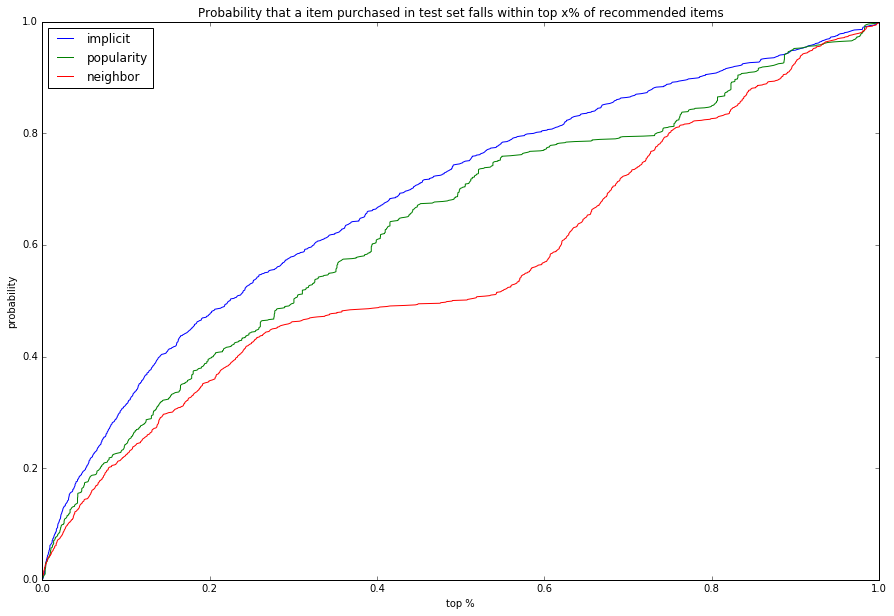

In [57]:
### draw the CDF 
rank_ui_sorted = np.sort(rank_ui)
rank_ui_popularity_sorted = np.sort(rank_ui_popularity)
rank_ui_neighbor_sorted = np.sort(rank_ui_neighbor)

yvals = np.arange(len(rank_ui_sorted)) / float(len(rank_ui_sorted))

plt.figure(figsize=(15,10))
plt.plot(rank_ui_sorted, yvals)
plt.plot(rank_ui_popularity_sorted, yvals)
plt.plot(rank_ui_neighbor_sorted, yvals)

plt.xlabel("top %")
plt.ylabel("probability")
plt.legend(["implicit", "popularity", "neighbor"], loc="upper left")
plt.title("Probability that a item purchased in test set falls within top x% of recommended items")

plt.show()